In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

(sec:theory_measurementError)=
# Measurement Error

Random sampling and random assignment introduce chance in the survey and experimental process to control for selection (and other kinds of) bias.  These random processes also enable us to quantify the variability in our observed results.  In many settings, measurement error also follows a chance process. As mentioned in Section {numref}`sec:scope_construct`, instruments typically have an error associated with them, and by taking repeated measurements on the same object, we can quantify the variability in the instrument. However to detect bias, we need a comparison to a more accurate instrument or to a standard with known measurement. For example, the International Bureau of Weights and Measures in Sèvres, France has kept a one kilogram cylinder of platinum since 1889 to calibrate instruments. (In 2011, the definition of the kilogram changed to no longer rely on a physical object, and instead be defined by a physical constant—Planck's constant—because the standard in France was found to have lost 50 micrograms in comparison to other copies of the standard kilogram). 

The following example, gives a picture of the variation in measurements of a device to measure air quality. 

## Air Quality Measurements

PurpleAir provides a sensor data download tool so anyone can access air quality measurements from their map. 

These data are available in 10 minute intervals for any sensor on the map.   
To get a sense of the size of the variability of one sensor, we downloaded the data for one sensor for a 36-hour period and selected four 30-minute periods (three consecutive measurements) for a total of 12 measurement.  

In [2]:
pm = pd.read_csv('data/purpleAir30minsample.csv')
pm

,pm2.5,time
0,9.48,A
1,9.32,A
2,9.29,A
...,...,...
9,15.31,D
10,15.49,D
11,14.72,D


The feature `pm2.5` refers to amount of particulate matter with a diameter smaller than 2.5 micrometers in the air. The unit of measurement is micrograms per cubic meter (μg/m3). These measurements are 10-minute averages.

The time periods are simply denoted, A, B, C, and D.

A plot of the quantity of particulate matter by time period gives us a basic sense of variability in the instrument. In each time period, the measurements cluster around a value, say about 12 for time period C. And we also notice
that the time periods have quite different levels of PM2.5, at least in comparison to the variability of the measurements taken close in time.

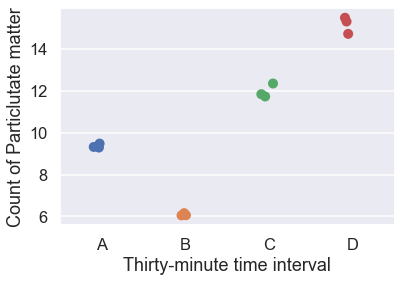

In [3]:
sns.stripplot(data=pm, x="time", y="pm2.5",  dodge=True, size=10)
plt.xlabel("Thirty-minute time interval")
plt.ylabel("Count of Particlutate matter");

We can estimate the standard deviation of the instrument by using the standard deviation for each group of three measurements.



In [4]:
mean_time = pm.groupby('time')['pm2.5'].std()
mean_time

time
A    0.10
B    0.06
C    0.33
D    0.40
Name: pm2.5, dtype: float64

In [5]:
np.sqrt(np.mean(mean_time**2))

0.26730132809247314

An estimate of the typical error for PM2.5 measurements from this instrument is about 0.27.